Epoch 1/30


d:\Venv\envs\TarRec\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.3216 - loss: 2.1654 - val_accuracy: 0.5385 - val_loss: 1.2935 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3849 - loss: 1.2833 - val_accuracy: 0.4872 - val_loss: 1.2739 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.5004 - loss: 1.1812 - val_accuracy: 0.6581 - val_loss: 1.1434 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7165 - loss: 0.8855 - val_accuracy: 0.7436 - val_loss: 1.0706 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.7792 - loss: 0.7141 - val_accuracy: 0.7436 - val_loss: 1.1238 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8398 - loss: 0.6122 - val_accuracy: 0.7436 - val_loss: 1.2376 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8624 - loss: 0.5067 - val_accurac

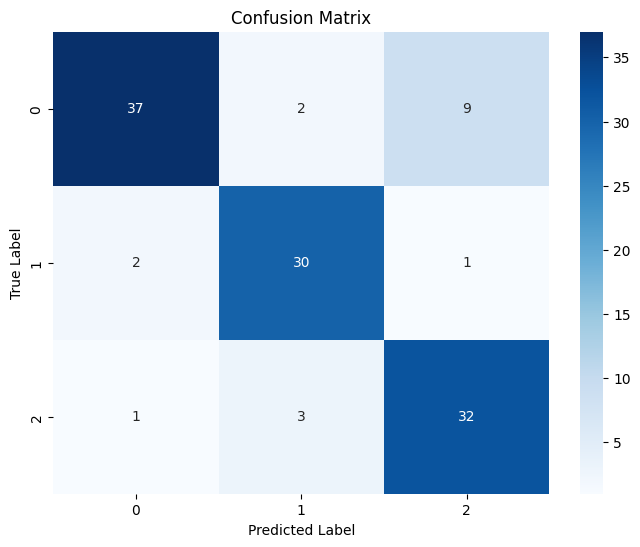

✅ 模型已保存为 cnn_MFCC_model_abs.keras


In [6]:
import random
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# **设置随机种子**
SEED = 300   #300的时候效果不错
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# **1️⃣ 加载数据**
X_train = np.load(r"D:\Dataset\Temp_Results\MFCC\X_train_mfcc_cnn.npy")
Y_train = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_train.npy")
X_test = np.load(r"D:\Dataset\Temp_Results\MFCC\X_test_mfcc_cnn.npy")
Y_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_test.npy")

# **2️⃣ 数据预处理**
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

num_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

# **3️⃣ 构建 CNN 模型**
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.0005), input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    
    Dense(num_classes, activation='softmax')
])

# **4️⃣ 编译模型**
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **5️⃣ 训练模型，使用 EarlyStopping 和 ReduceLROnPlateau**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(X_train, Y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, Y_test),
                    callbacks=[reduce_lr])  #去掉了early stop

# **6️⃣ 评估模型**
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print(f"\n✅ 测试集准确率: {test_acc:.4f}")

# **7️⃣ 计算分类报告和混淆矩阵**
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"🎯 测试准确率: {accuracy:.4f}")

print("\n📊 分类报告:")
print(classification_report(Y_true, Y_pred_classes))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **8️⃣ 保存模型**
model.save("cnn_MFCC_model_abs.keras")
print("✅ 模型已保存为 cnn_MFCC_model_abs.keras")
